This tutorial trains a 3D densenet for lung lesion classification from CT image patches. 

The goal is to demonstrate MONAI's class activation mapping functions for visualising the classification models.

For the demo data:
- Please see the `bbox_gen.py` script for generating the patch classification data from MSD task06_lung (available via `monai.apps.DecathlonDataset`).
- Alternatively, the patch dataset (~130MB) is available for direct downloading at: https://drive.google.com/drive/folders/1vl330aJew1NCc31IVYJSAh3y0XdDdydi

In [ ]:
%matplotlib inline

In [ ]:
%pip install "git+https://github.com/Project-MONAI/MONAI#egg=MONAI[nibabel, tqdm]"

In [ ]:
import os
import glob
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import monai
from monai.transforms import (
    AddChanneld, Compose, LoadImaged, RandRotate90d, 
    Resized, ScaleIntensityRanged, ToTensord, 
    RandFlipd, RandSpatialCropd,
)
from monai.metrics import compute_occlusion_sensitivity

monai.config.print_config()
random_seed = 42
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
use_patch_dataset=True  # switch this to use partial dataset or whole thing

directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
data_path=os.path.join(root_dir, "patch")
if use_patch_dataset:
    !cd {root_dir} && [ -f "lung_lesion_patches.tar.gz" ] || gdown --id 1Jte6L7B_5q9XMgOCAq1Ldn29F1aaIxjW \
        && mkdir -p {data_path} && tar -xvf "lung_lesion_patches.tar.gz" -C {data_path} > /dev/null
else:
    monai.apps.DecathlonDataset(root_dir=root_dir, task="Task06_Lung", section="training", download=True)
    %run -i './bbox_gen.py {root_dir}'

Collecting all the patch data


In [30]:
lesion = glob.glob(os.path.join(data_path,"lesion_*"))
non_lesion = glob.glob(os.path.join(data_path,"norm_*"))
labels = np.asarray([[0., 1.]] * len(lesion) + [[1., 0.]] * len(non_lesion))

all_files = [{"image": img, "label": label} for img, label in zip(lesion + non_lesion, labels)]
random.shuffle(all_files)
print(f"total items: {len(all_files)}")

total items: 251


Split the data into 80% training and 20% validation


In [31]:
train_frac, val_frac = 0.8, 0.2
n_train = int(train_frac * len(all_files)) + 1
n_val = min(len(all_files) - n_train, int(val_frac * len(all_files)))

train_files, val_files = all_files[:n_train], all_files[-n_val:]
train_labels = [data["label"] for data in train_files]
print(f"total train: {len(train_files)}")

val_labels = [data["label"] for data in val_files]
n_neg, n_pos = np.sum(np.asarray(val_labels) == 0), np.sum(np.asarray(val_labels)== 1)
print(f"total valid: {len(val_labels)}")

total train: 201
total valid: 50


Create the data loaders. These loaders will be used for both training/validation, as well as visualisations.

In [32]:
# Define transforms for image
win_size = (196, 196, 144)
train_transforms = Compose(
    [
        LoadImaged("image"),
        AddChanneld("image"),
        ScaleIntensityRanged("image", a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
        RandFlipd("image", spatial_axis=0, prob=0.5),
        RandFlipd("image", spatial_axis=1, prob=0.5),
        RandFlipd("image", spatial_axis=2, prob=0.5),
        RandSpatialCropd("image", roi_size=(64, 64, 40)),
        Resized("image", win_size, "trilinear", True),
        RandRotate90d("image", prob=0.5, spatial_axes=[0, 1]),
        ToTensord("image"),
    ]
)
val_transforms = Compose(
    [
        LoadImaged("image"),
        AddChanneld("image"),
        ScaleIntensityRanged("image", a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
        Resized("image", win_size, "trilinear", True),
        ToTensord(("image", "label")),
    ]
)

train_ds = monai.data.LMDBDataset(data=train_files, transform=train_transforms)
train_loader = monai.data.DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=True)
val_ds = monai.data.LMDBDataset(data=val_files, transform=val_transforms)
val_loader = monai.data.DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=True)

Start the model, loss function, and optimizer.

In [ ]:
model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
bce = torch.nn.BCEWithLogitsLoss()
def criterion(logits, target): 
    return bce(logits.view(-1), target.view(-1))
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

Run training iterations.

In [ ]:
from IPython.display import clear_output

# start training
val_interval, total_epochs = 1, 30
best_metric = best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
scaler = torch.cuda.amp.GradScaler()
for epoch in range(total_epochs):
    clear_output()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{total_epochs}")
    model.train()
    epoch_loss = step = 0
    for batch_data in train_loader:
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        if step % 50 == 0:
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        step += 1
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric >= best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
            torch.save(model.state_dict(), "model_classification3d_array.pth")
            print(
                "current epoch: {} current accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

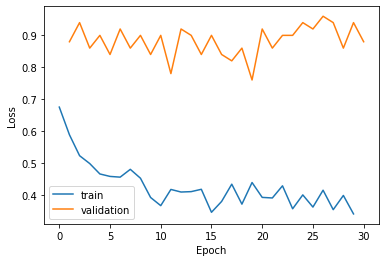

In [ ]:
plt.plot(epoch_loss_values,label='train')
val_epochs=np.linspace(1, total_epochs,np.floor(total_epochs/val_interval).astype(np.int32))
plt.plot(val_epochs, metric_values,label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

Initialise the CAM visualiser

In [79]:
model_3d = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
model_3d.load_state_dict(torch.load("model_classification3d_array.pth"))
model_3d.eval()
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAM(nn_module=model_3d, target_layers="class_layers.relu")
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print("original feature shape", cam.feature_map_size([1, 1] + list(win_size), device))
print("upsampled feature shape", [1, 1] + list(win_size))

original feature shape torch.Size([1, 1, 6, 6, 4])
upsampled feature shape [1, 1, 196, 196, 144]


# GradCAM and occlusion sensitivity for elements in confusion matrix

When visualising a network, we want to get a feeling for why/when it works and why/when it doesn't. 

For this, we'll find four examples, corresponding to all the elements in the confusion matrix (TP, TN, FP, FN) and then visualise them.

In [ ]:
# Get examples of TP, FP, TN, FN
confusion_examples = {
    "TP -- input: lesion, predicted: lesion": None,
    "FN -- input: lesion, predicted: non-lesion": None,
    "FP -- input: non-lesion, predicted: lesion": None,
    "TN -- input: non-lesion, predicted: non-lesion": None,
}

np.random.seed(random_seed)
rand_indices = np.arange(len(train_ds))
np.random.shuffle(rand_indices)
for idx in rand_indices:
    
    data = train_ds[idx]  # this fetches training data with random augmentations    
    # if label==0, lesion. else non-lesion.
    label = data["label"][0]

    # only bother predicting if we're missing a spot in the confusion matrix
    vals = list(confusion_examples.values())
    if (label == 0 and None not in vals[0:2]):
        continue
    if (label == 1 and None not in vals[3:4]):
        continue
    
    image = data["image"].to(device).unsqueeze(0)
    predicted_label = model_3d(image).argmax(1).item()

    if label == 0 and predicted_label == 0:
        confusion_examples["TP -- input: lesion, predicted: lesion"] = idx
    elif label == 0 and predicted_label == 1:

        confusion_examples["FN -- input: lesion, predicted: non-lesion"] = idx
    elif label == 1 and predicted_label == 0:

        confusion_examples["FP -- input: non-lesion, predicted: lesion"] = idx
    elif label == 1 and predicted_label == 1:

        confusion_examples["TN -- input: non-lesion, predicted: non-lesion"] = idx

for name, item in confusion_examples.items():
    print(f"{name}, idx: {item}")

TP -- input: lesion, predicted: lesion, idx: 69
FN -- input: lesion, predicted: non-lesion, idx: 45
FP -- input: non-lesion, predicted: lesion, idx: 115
TN -- input: non-lesion, predicted: non-lesion, idx: 171


100%|██████████| 81/81 [00:03<00:00, 20.60it/s]


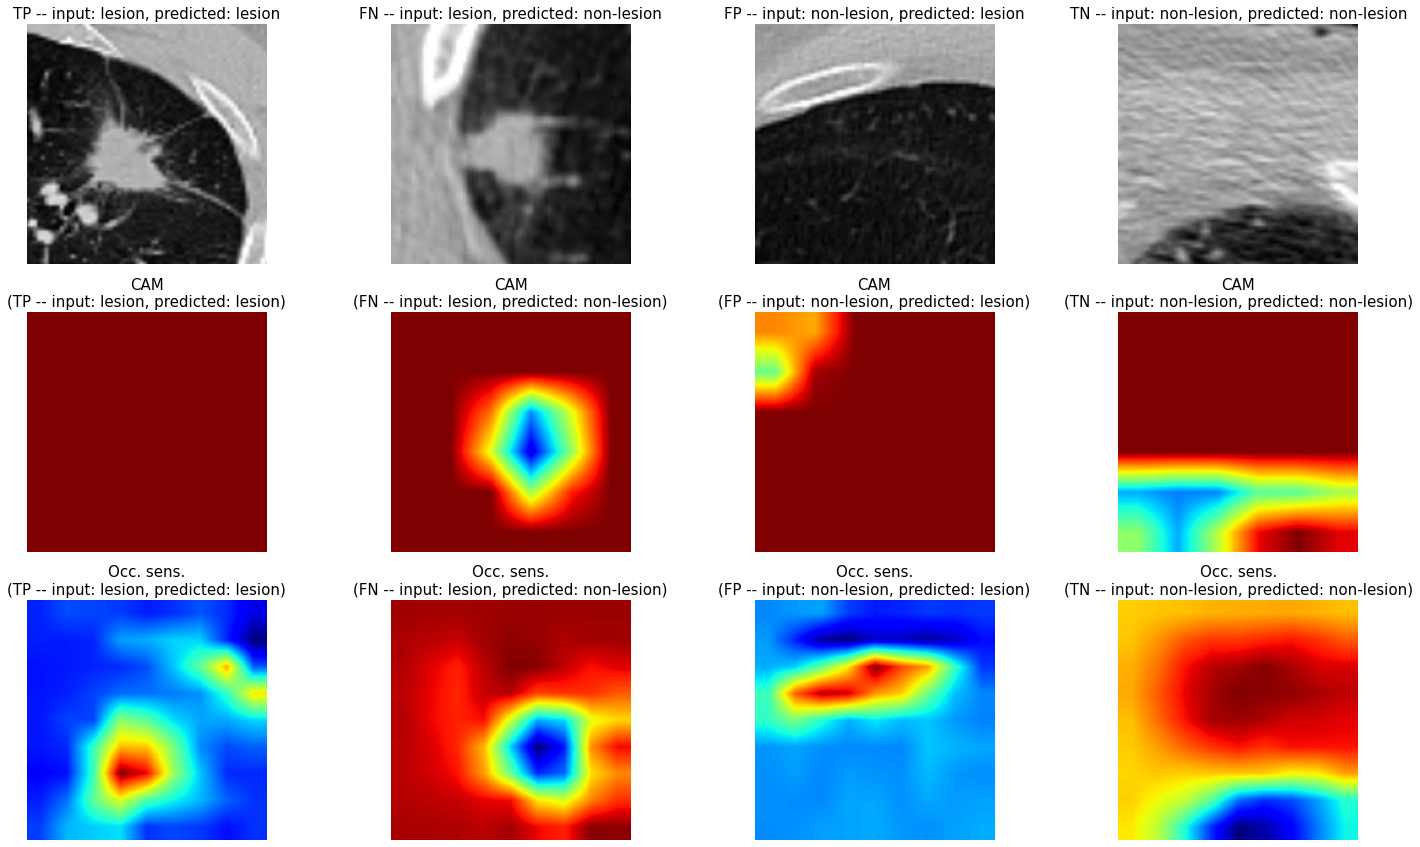

In [ ]:
train_transforms.set_random_state(random_seed)
subplot_shape = [3, 4]
plt.subplots(*subplot_shape, figsize=(25,15), facecolor='white')
for idx, (name, item) in enumerate(confusion_examples.items()):
    the_slice = 72
    # run CAM
    data = train_ds[item]  # this fetches training data with random augmentations
    image, label = data["image"].to(device).unsqueeze(0), data["label"]
    cam_result = cam(x=image, class_idx=1)
    
    # run occlusion
    bounds=[-1, -1, -1, -1, -1, -1, the_slice, the_slice]
    predicted_label = model_3d(image).argmax(1).item()
    occ_result = compute_occlusion_sensitivity(model_3d, image, predicted_label, margin=10, n_batch=1, b_box=bounds, stride=20, upsample_mode='trilinear')

    # the rest is for visualisations
    img = image.detach().cpu().numpy()
    mix = cam_result[0]
    ax = plt.subplot(*subplot_shape, idx + 1); plt.imshow(img[0, 0, :, :, the_slice], cmap='gray')
    ax.set_title(name, fontsize=15)
    plt.axis('off')
    fig = plt.subplot(*subplot_shape, subplot_shape[1] + idx + 1); plt.imshow(mix[0, :, :, the_slice], cmap="jet", vmin=0, vmax=1)
    fig.set_title(f"CAM\n({name})", fontsize=15)
    plt.axis('off')
    fig = plt.subplot(*subplot_shape, 2*subplot_shape[1] + idx + 1); plt.imshow(occ_result, cmap='jet')
    fig.set_title(f"Occ. sens.\n({name})", fontsize=15)
    plt.axis('off')

In [ ]:
from monai.visualize import plot_2d_or_3d_image
from torch.utils.tensorboard import SummaryWriter

with SummaryWriter(log_dir="logs") as writer:
    plot_2d_or_3d_image(mix[None], step=0, writer=writer, tag="CAM")
    plot_2d_or_3d_image(image[None], step=0, writer=writer, tag="Input")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs